In [204]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from scipy.signal import savgol_filter

In [205]:
def create_time_data(start_time, end_time, time_delta):
    
    timestamps = []
    current_time = start_time
    while current_time <= end_time:
        timestamps.append(current_time)
        current_time += time_delta
        
    return timestamps

def create_base_consumption(timestamps, base_consumption_metadata):
    t = np.linspace(0, (timestamps[-1]-timestamps[0])/timedelta(hours=1), len(timestamps))
    n_points = len(t)
    base_consumption = np.ones(n_points) * base_consumption_metadata["mean_base"]

    
    # Morning peak (7h-9h)
    for peak in base_consumption_metadata["peaks"]:
        peak_consumption = np.zeros_like(timestamps)
        mask = [(timestamp>=peak["start"]) & (timestamp<=peak["end"]) for timestamp in timestamps]
        t_normalized = (t[mask] - np.min(t[mask])) / (np.max(t[mask]) - np.min(t[mask]))
        peak_consumption[mask] = peak["peak"] * np.sin(np.pi * t_normalized )
        base_consumption = base_consumption + peak_consumption
    
    
    # Combine, add noise and smooth
    base_consumption += np.random.normal(0, 0.05, n_points)
    base_consumption = savgol_filter(base_consumption, window_length=5, polyorder=3)
    
    return base_consumption

def create_solar_production(timestamps, solar_production_metadata):
    t = np.linspace(0, (timestamps[-1]-timestamps[0])/timedelta(hours=1), len(timestamps))
    t_normalized = t
    solar_production = np.zeros_like(t)
    mask = [(timestamp>=solar_production_metadata["start"]) & (timestamp<=solar_production_metadata["end"]) for timestamp in timestamps]
    t_normalized = (t[mask] - np.min(t[mask])) / (np.max(t[mask]) - np.min(t[mask]))

    t_peak = np.mean(t[mask])
    solar_production[mask] = -solar_production_metadata["peak"] * np.sin(np.pi * t_normalized) * np.exp(-((t[mask] - t_peak) ** 2) / 8)
    
    return solar_production


In [206]:
def strategy_scheduled(timestamps, cet_properties, scheduling_strategy_metadata):
    
    cet_consumption = np.zeros_like(timestamps)
    cet_mask = [(t >= scheduling_strategy_metadata["start"]) & (t < scheduling_strategy_metadata["start"] + cet_properties["max_duration"]) for t in timestamps]
    cet_consumption[cet_mask] = cet_properties["power"]
    
    return cet_consumption

def strategy_solar_only(timestamps, solar_production, base_consumption, cet_properties, solar_only_strategy_metadata):
    """Stratégie 2: 100% solaire"""
    cet_consumption = np.zeros_like(timestamps)
    threshold = solar_only_strategy_metadata["threshold"]*cet_properties["power"]
    
    # Calculer la puissance disponible
    available_power = -solar_production - base_consumption
    
    # Initialiser les compteurs
    state_duration = timedelta(minutes=0)
    total_running_duration = timedelta(minutes=0)  # Compteur pour la durée totale de fonctionnement
    state_init_timestamp = timestamps[0]
    is_running = False
    
    for i in range(len(timestamps)):
        
        state_duration = timestamps[i] - state_init_timestamp
        # CET is running        
        if is_running:

            available_power[i] -= cet_properties["power"]
            # Stop condition #1 because CET has run long enough to heat water. All future CET values are null
            if (total_running_duration + state_duration) >= cet_properties["max_duration"]:
                break

            # Stop condition #2 because energy is taken from the grid.
            if available_power[i] <= 0 and state_duration >= cet_properties["min_duration"]:
                total_running_duration += state_duration
                is_running = False
                state_init_timestamp = timestamps[i] # new state initial timestamp

            # Otherwise, continue running (either for min_duration reason or enough production)
            else:
                cet_consumption[i] = cet_properties["power"]
                state_duration = timestamps[i] - state_init_timestamp

        # CET is off
        else:
            # Start condition = enough production and min_duration limit is exceeded
            if available_power[i] >= threshold and state_duration >= cet_properties["min_duration"]:
                is_running = True
                state_init_timestamp = timestamps[i] # new state initial timestamp
                cet_consumption[i] = cet_properties["power"]

    return cet_consumption

def strategy_maximize_solar(timestamps, solar_production, base_consumption, cet_properties, max_solar_strategy_metadata):
    """Stratégie 3: Maximiser l'autoconsommation avec limite de 4h"""
    cet_consumption = np.zeros_like(timestamps)
    threshold = max_solar_strategy_metadata["threshold"]*cet_properties["power"]
    
    # Calculer la puissance disponible
    available_power = -solar_production - base_consumption

    # Initialiser les compteurs
    state_duration = timedelta(minutes=0)
    total_running_duration = timedelta(minutes=0)  # Compteur pour la durée totale de fonctionnement
    state_init_timestamp = timestamps[0]
    is_running = False
    
    for i in range(len(timestamps)):
        
        state_duration = timestamps[i] - state_init_timestamp
        # CET is running        
        if is_running:

            consumption = base_consumption[i] + cet_properties["power"]
            available_power[i] -= cet_properties["power"]
            # Stop condition #1 because CET has run long enough to heat water. All future CET values are null
            if (total_running_duration + state_duration) >= cet_properties["max_duration"]:
                break

            # Stop condition #2 because solar production covers less than a percentage of the CET consumption
            if available_power[i] < -1 and state_duration >= cet_properties["min_duration"]:
                total_running_duration += state_duration
                is_running = False
                state_init_timestamp = timestamps[i] # new state initial timestamp

            # Otherwise, continue running (either for min_duration reason or enough production)
            else:
                cet_consumption[i] = cet_properties["power"]
                state_duration = timestamps[i] - state_init_timestamp

        # CET is off
        else:
            # Start condition = enough production and min_duration limit is exceeded
            if available_power[i] >= 0 and state_duration >= cet_properties["min_duration"]:
                is_running = True
                state_init_timestamp = timestamps[i] # new state initial timestamp
                cet_consumption[i] = cet_properties["power"]
    
    return cet_consumption


def strategy_optim(timestamps, solar_production, base_consumption, cet_properties, optim_strategy_metadata):
    """Stratégie 4: Optimiser la facture"""
    cet_consumption = np.zeros_like(timestamps)
    threshold = optim_strategy_metadata["threshold"]*cet_properties["power"]
    
    # Calculer la puissance disponible
    available_power = -solar_production - base_consumption

    # Initialiser les compteurs
    state_duration = timedelta(minutes=0)
    total_running_duration = timedelta(minutes=0)  # Compteur pour la durée totale de fonctionnement
    state_init_timestamp = timestamps[0]
    is_running = False
    
    for i in range(len(timestamps)):
        
        state_duration = timestamps[i] - state_init_timestamp
        # CET is running        
        if is_running:

            consumption = base_consumption[i] + cet_properties["power"]
            solar_ratio = abs(solar_production[i])/consumption
            # Stop condition #1 because CET has run long enough to heat water. All future CET values are null
            if (total_running_duration + state_duration) >= cet_properties["max_duration"]:
                break

            # Stop condition #2 because solar production covers less than a percentage of the CET consumption
            if solar_ratio <= 0.3 and state_duration >= cet_properties["min_duration"]:
                total_running_duration += state_duration
                is_running = False
                state_init_timestamp = timestamps[i] # new state initial timestamp

            # Otherwise, continue running (either for min_duration reason or enough production)
            else:
                cet_consumption[i] = cet_properties["power"]
                state_duration = timestamps[i] - state_init_timestamp

        # CET is off
        else:
            # Start condition = enough production and min_duration limit is exceeded
            if available_power[i] >= 0.5*cet_properties["power"] and state_duration >= cet_properties["min_duration"]:
                is_running = True
                state_init_timestamp = timestamps[i] # new state initial timestamp
                cet_consumption[i] = cet_properties["power"]
    
    return cet_consumption


In [207]:
def calculate_metrics(solar_production, consumption, grid_exchanges, time_delta, cet_consumption):
    """Calcule les métriques de performance pour une stratégie donnée"""
    
    # Convertir le time_delta en heures
    dt_hours = time_delta.total_seconds() / 3600
    
    # Production solaire totale (uniquement les valeurs négatives car production = négatif dans notre convention)
    total_production = -np.sum(solar_production[solar_production < 0]) * dt_hours  # kWh
    
    # Consommation totale
    total_consumption = np.sum(consumption) * dt_hours  # kWh
    
    # Énergie importée du réseau (valeurs positives des échanges réseau)
    grid_imports = np.sum(grid_exchanges[grid_exchanges > 0]) * dt_hours  # kWh
    
    # Énergie exportée vers le réseau (valeurs négatives des échanges réseau)
    grid_exports = -np.sum(grid_exchanges[grid_exchanges < 0]) * dt_hours  # kWh
    
    # Calcul de l'autoconsommation
    energy_self_consumed = total_production - grid_exports
    self_consumption_rate = (energy_self_consumed / total_production * 100) if total_production > 0 else 0
    
    # Calcul de l'indépendance énergétique
    energy_independence_rate = ((total_consumption - grid_imports) / total_consumption * 100) if total_consumption > 0 else 0
    
    # Calcul des coûts
    import_cost = grid_imports * 2  # 2€/kWh pour l'import
    export_revenue = grid_exports * 1  # 1€/kWh pour l'export
    total_cost = import_cost - export_revenue
    mean_cost_per_kwh = total_cost/total_consumption
    
    # Calcul du temps de fonctionnement du CET
    cet_runtime_points = np.sum(cet_consumption > 0)  # Nombre de points où le CET fonctionne
    print(cet_runtime_points)
    cet_runtime_hours = cet_runtime_points * dt_hours  # Conversion en heures
    
    return {
        'production_totale': total_production,
        'consommation_totale': total_consumption,
        'import_reseau': grid_imports,
        'export_reseau': grid_exports,
        'taux_autoconsommation': self_consumption_rate,
        'taux_independance': energy_independence_rate,
        'cout moyen': mean_cost_per_kwh,
        'temps_fonctionnement_cet': cet_runtime_hours
    }

In [212]:
def plot_results(timestamps, base_consumption, solar_production, cet_consumptions, time_delta):
    strategies = ['Programmé', '100% Solaire', 'Max. Autoconso.','Optimiz']
    fig = plt.figure(figsize=(15, 15))
    
    # Création d'une grille de sous-graphiques
    gs = plt.GridSpec(5, 1, height_ratios=[3, 3, 3, 3, 2], hspace=1)
    
    # Création des graphiques de puissance
    axs = [fig.add_subplot(gs[i]) for i in range(4)]
    
    # Liste pour stocker les métriques de chaque stratégie
    all_metrics = []
    
    for idx, (strategy_name, cet_consumption) in enumerate(zip(strategies, cet_consumptions)):
        ax = axs[idx]
        consumption = base_consumption + cet_consumption
        grid_exchanges = consumption + solar_production
        
        # Calcul des métriques
        metrics = calculate_metrics(solar_production, consumption, grid_exchanges, time_delta, cet_consumption)
        all_metrics.append(metrics)
        
        # Affichage des courbes
        width = time_delta.total_seconds() / (3600 * 24)
        ax.bar(timestamps, consumption, width, label='Consommation', color='#FF6B6B', alpha=0.7)
        ax.bar(timestamps, solar_production, width, label='Production solaire', color='#4ECB71', alpha=0.7)
        ax.plot(timestamps, grid_exchanges, 'b-', label='Échanges réseau', linewidth=2)
        
        ax.set_xlabel('Heure')
        ax.set_ylabel('Puissance (kW)')
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax.legend(loc='upper right')
        ax.set_title(f'Stratégie: {strategy_name}')
        ax.set_ylim(-3, 3)
    
    # Ajout d'un tableau comparatif des métriques
    ax_table = fig.add_subplot(gs[4])
    ax_table.axis('tight')
    ax_table.axis('off')
    
    # Préparation des données pour le tableau
    table_data = [
        ['Métrique'] + strategies,
        ['Temps de fonctionnement CET (h)', 
         f"{all_metrics[0]['temps_fonctionnement_cet']:.2f}",
         f"{all_metrics[1]['temps_fonctionnement_cet']:.2f}",
         f"{all_metrics[2]['temps_fonctionnement_cet']:.2f}",
         f"{all_metrics[3]['temps_fonctionnement_cet']:.2f}"],
        ['Taux d\'autoconsommation (%)', 
         f"{all_metrics[0]['taux_autoconsommation']:.1f}",
         f"{all_metrics[1]['taux_autoconsommation']:.1f}",
         f"{all_metrics[2]['taux_autoconsommation']:.1f}",
         f"{all_metrics[3]['taux_autoconsommation']:.1f}"],
        ['Taux d\'indépendance (%)', 
         f"{all_metrics[0]['taux_independance']:.1f}",
         f"{all_metrics[1]['taux_independance']:.1f}",
         f"{all_metrics[2]['taux_independance']:.1f}",
         f"{all_metrics[3]['taux_independance']:.1f}"],
        ['Coût moyen (€/kWh)', 
         f"{all_metrics[0]['cout moyen']:.2f}",
         f"{all_metrics[1]['cout moyen']:.2f}",
         f"{all_metrics[2]['cout moyen']:.2f}",
         f"{all_metrics[3]['cout moyen']:.2f}"],
        ['Production totale (kWh)', 
         f"{all_metrics[0]['production_totale']:.2f}",
         f"{all_metrics[1]['production_totale']:.2f}",
         f"{all_metrics[2]['production_totale']:.2f}",
         f"{all_metrics[3]['production_totale']:.2f}"],
        ['Consommation totale (kWh)', 
         f"{all_metrics[0]['consommation_totale']:.2f}",
         f"{all_metrics[1]['consommation_totale']:.2f}",
         f"{all_metrics[2]['consommation_totale']:.2f}",
         f"{all_metrics[3]['consommation_totale']:.2f}"]
    ]
    
    table = ax_table.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    # Mise en forme du tableau
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#E6E6E6')
        elif col == 0:
            cell.set_text_props(weight='bold')
    
    plt.tight_layout()
    return fig, all_metrics

48
23
48
48


/var/folders/ts/9vfhl4251kd__twtz_zx5plsb57dt2/T/ipykernel_30292/3324551382.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


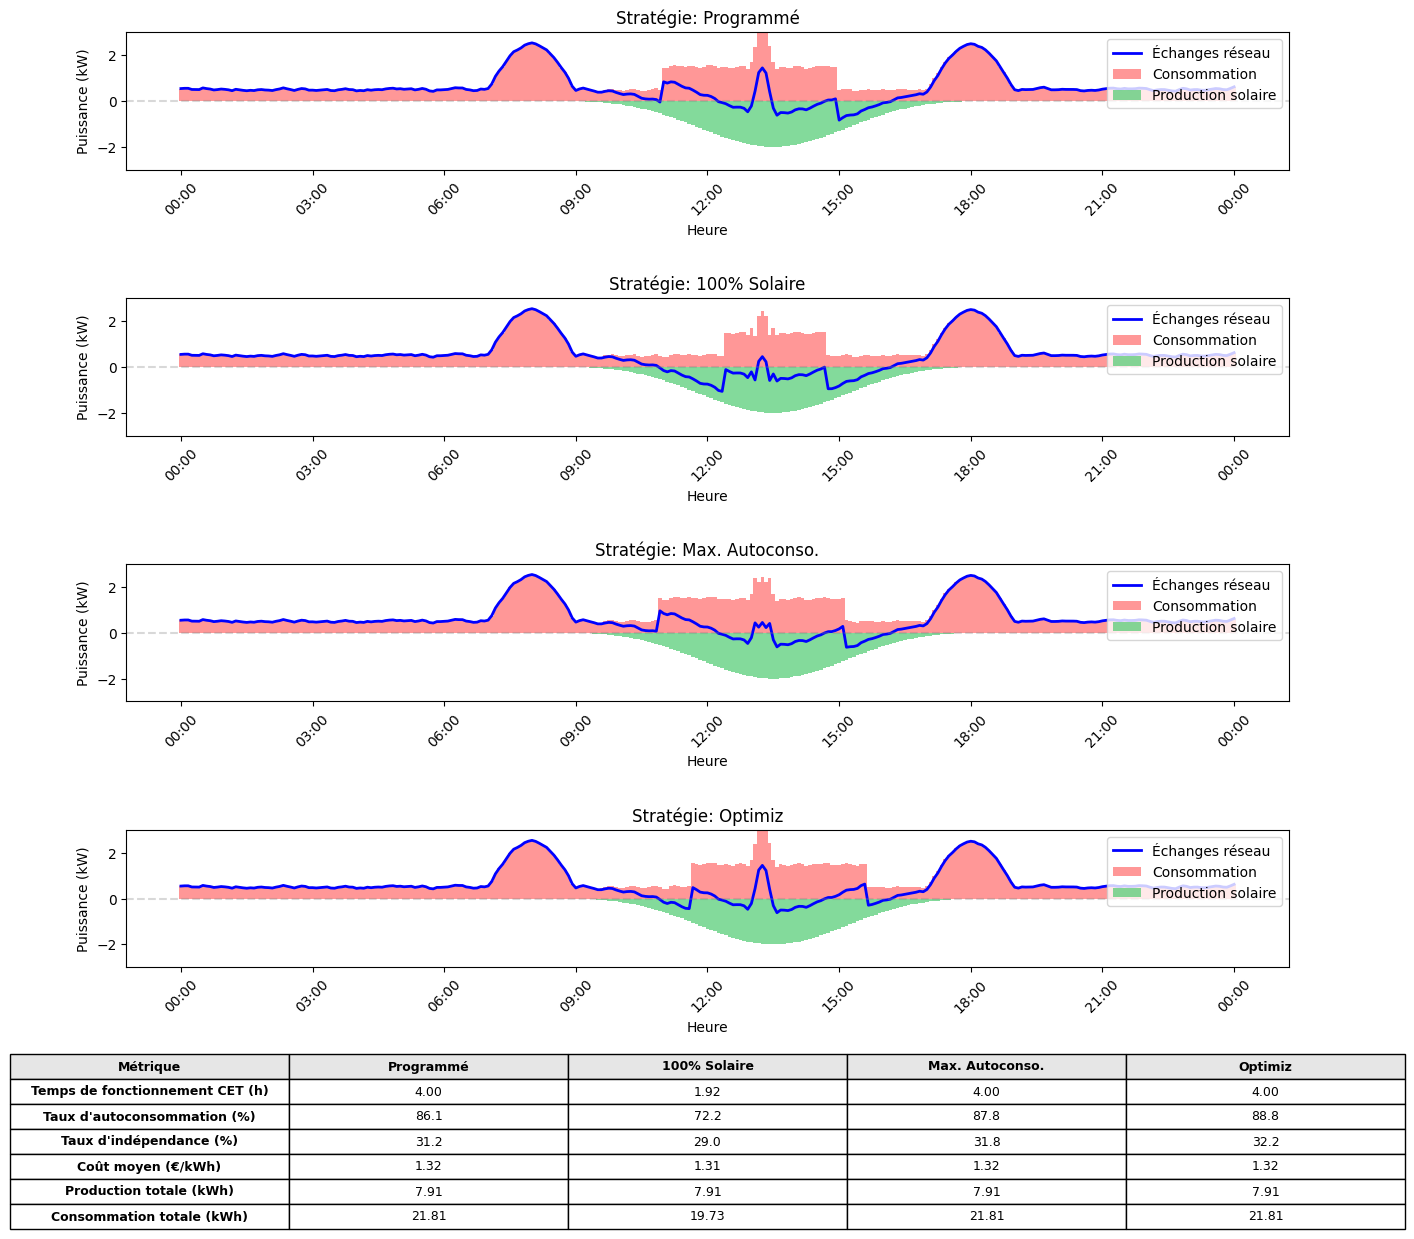

In [213]:
def main():
    # Création des données temporelles
    # 24h data
    start_time = datetime(2024, 1, 1, 0, 0)
    end_time = datetime(2024, 1, 2, 0, 0)
    time_delta = timedelta(minutes=5)
    timestamps = create_time_data(start_time, end_time, time_delta)
    
    # Création des données de base
    base_consumption_metadata = {
        "mean_base": 0.5,     #kW

        "peaks":[
        {
            "name": "morning_peak",
            "peak":2,                           #kW
            "start":datetime(2024, 1, 1, 7, 0), #h:mm
            "end":datetime(2024, 1, 1, 9, 0)    #h:mm
        },
        {
            "name": "evening_peak",
            "peak":2,       #kW
            "start":datetime(2024, 1, 1, 17, 0),#h:mm
            "end":datetime(2024, 1, 1, 19, 0)   #h:mm
        },
        {
            "name": "mid-day",
            "peak":2,       #kW
            "start":datetime(2024, 1, 1, 13, 0),#h:mm
            "end":datetime(2024, 1, 1, 13, 30)  #h:mm
        }]
    }

    solar_production_metadata = {
        "peak": 2,     #kW
        "start":datetime(2024, 1, 1, 9, 0), #h:mm
        "end":datetime(2024, 1, 1, 18, 0),    #h:mm
        }
    
    base_consumption = create_base_consumption(timestamps, base_consumption_metadata)
    solar_production = create_solar_production(timestamps, solar_production_metadata)
    
    # Application des trois stratégies
    cet_properties = {
        "power": 1, #kw
        "min_duration": timedelta(minutes = 15),
        "max_duration": timedelta(hours = 4)
    }
    
    scheduling_metadata = {
        "start":datetime(2024, 1, 1, 11, 0),  # 11h
    }

    solar_only_strategy_metadata = {
        "threshold": 1.1
    }
    
    max_solar_strategy_metadata = {
        "threshold": 0.5
    }
    
    cet_scheduled = strategy_scheduled(timestamps, cet_properties, scheduling_metadata)
    cet_solar_only = strategy_solar_only(timestamps, solar_production, base_consumption, cet_properties, solar_only_strategy_metadata)
    cet_maximize = strategy_maximize_solar(timestamps, solar_production, base_consumption, cet_properties, max_solar_strategy_metadata)
    cet_optimize = strategy_optim(timestamps, solar_production, base_consumption, cet_properties, max_solar_strategy_metadata)
    
    # Création du graphique comparatif avec métriques
    fig, metrics = plot_results(
        timestamps,
        base_consumption,
        solar_production,
        [cet_scheduled, cet_solar_only, cet_maximize, cet_optimize],
        time_delta
    )
    
    plt.show()

if __name__ == "__main__":
    main()